# Bias and Variance Problem
## Introduction

In this exercise, we will implement regularized linear regression to predict the water flowing out of the dam water. The project will investigate the bias-variance properties of a Machine Learning project. I'd like to thank Andrew Ng. This project is inspired from the Machine Learning course by [Andrew Ng (Stanford University)](https://www.coursera.org/learn/machine-learning/home/welcome) in Coursera.

The project consists of the following sections,

| Section | Part                                            |Explanation                                    | 
|---------|:-                                               |:-                                             |
| 1       | [Define Linear Regression Class](#section1)                             | The class serves as a self-built Linear Regression algorithm |
| 2       | [Water Flow Prediction # PART 1](#section2)     | Predict water flow with linear features |
| 3       | [Water Flow Prediction # PART 2](#section3)     | Predict water flow with higher polynomial features         |
| 4       | [Water Flow Prediction # PART 3](#section4)     | Tune the hyperparameter lambda for polynomial regression   |
| 5       | [Conclusion](#section5)     | Take aways of the project         |

<a id="section1"></a>
## 1:  Define a Linear Regression Class
The project will utilize the training set, cross-validation/evaluation set, and test set,

- A **training** set that your model will learn on: `X`, `y`
- A **cross validation** set to fit the regularization hyperparameter: `X_val`, `y_val`
- A **test** set to evaluate the hypothesis: `X_test`, `y_test`

The pipeline will be,

| Pipeline | Part               |Explanation                       | 
| ---------|:-                  |:-                                |
| 1        | Initialize   | Load the dataset. Assign training, cross-validation, and test set |
| 2        | Plot the dataset   | Using Matplotlib pyplot          |
| 3        | Calculate h_theta            | Calculate the $h_{\theta}$    |
| 4        | Cost Function      | Cost of Regularized Linear Regression |
| 5        | Scipy Optimization | Using `scipy.optimize.minimize`  |
| 5        | Plot fit | Plot the hypothesis  |

In [1]:
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from scipy import optimize
from scipy.io import loadmat

In [2]:
class LinearRegression:
    def __init__(self):
        '''
        The method will load the dataset and initialize important value. 
        
        STEPS
        -----
        1. Loading dataset : Refer to the load_data method for details
        '''
        # STEP 1
        self.load_data()
                
    def load_data(self):
        '''
        The method will load the dataset from a CSV file named 'ex5data1.txt'.
        Note: The raw dataset has been shuffled randomly before.
        
        STEPS
        -----
        1. Load the CSV file
        2. Assign the following variables,
            m_training : number of training set examples
            X : training set features,
                change in water level
            y : water flowing out of the dam,
        3. Assign the test and evaluation set
            X_test, y_test : dataset for the test set
            X_eval, y_eval : dataset for the evaluation/cross-validation
        '''
        
        # STEP 1
        self.dataset = loadmat(os.path.join('Data', 'ex5data1.mat'))
        
        # STEP 2
        self.X = self.dataset['X']
        self.y = self.dataset['y'][:, 0]
        self.n = self.X.size
        
        # STEP 3
        self.X_test = self.dataset['Xtest']
        self.y_test = self.dataset['ytest'][:, 0]
        
        self.X_val = self.dataset['Xval']
        self.y_val = self.dataset['yval'][:, 0]
        self.m_val = self.y_val.size
        
    def features_mapping(self, X, p):
        '''
        The method will map the features into n-th higher polynomials.
        The method is translated from the Andrew Ng Matlab function. 
        
        PARAMETERS
        ----------
        X : Numpy array
            A matrix of shape (m, n), containing n features values of all examples.
        p : int
            The polynomial power to map the features. 

        RETURNS
        -------
        X_polynomials : Numpy array
                        A matrix of shape (m x p) where p is the polynomial 
                        power and m is the number of examples. That is:

                        X_poly[i, :] = [X[i], X[i]**2, X[i]**3 ...  X[i]**p]
        
        STEPS
        -----
        1. Initialize values
        2. Features mapping through loop
        '''
        
        # STEP 1
        m = X.shape[0]
        n = X.shape[1]
        X_polynomials = np.zeros((m,p))
        
        # STEP 2
        for i in range(p):
            X_polynomials[:, i] = X[:, 0] ** (i + 1)
        
        return X_polynomials
    
    def features_normalization(self, X):
        '''
        The method will normalize the features' values so it has a mean
        of 0 and a standard deviation of 1. The process will implement 
        vectorization in Numpy. After normalization, the bias term will be
        assigned to the features as X[0].
        
        RETURN
        ------
            X_norm : normalized features matrix with a size of m x n, 
                X[0] : Bias term
                X[1] : Feature #1
                X[2] : Feature #2
                 .
                 .
                X[n] : Feature #n
                
        STEPS
        ----
        1. Initialize matrix size,
            X_norm = copy features' matrix size
            mean = create mean expected matrix size
            sigma = create standard deviation expected matrix size
        
        2. Calculate the values,
            mean = calculate the mean of each features using numpy
            sigma = calculate the standard deviation of each features using
                    numpy
        
        3. Calculate normalized features. 
        4. Add bias term to the normalized features.
            X_norm includes normalized features (as X[1] and X[2]) and bias term
            as X[0]
        '''
        
        # STEP 1
        X_norm = X.copy()
        m = X.shape[0]
        mean = np.zeros(X_norm.shape[1])
        sigma = np.zeros(X_norm.shape[1])
        
        # STEP 2
        mean = np.mean(X_norm, axis=0)
        
        # STEP 3
        X_norm = X - mean
        mean = np.mean(X_norm, axis=0)
        sigma = np.std(X_norm, axis=0, ddof=1)
        X_norm = X_norm / sigma
        
        return X_norm, mean, sigma
        
    def plot_data(self, X, y):
        '''
        The method will plot the select examples randomly and plot it.
        
        PARAMETERS
        ----------
        X : Numpy array
            A matrix of shape (m, n), containing n features values of all examples.
        
        STEPS
        -----
        1. Assign values to plot
        2. Plot the values
        '''
        # STEP 1
        X_plot = X.copy()
        y_plot = y.copy()
        
        # STEP 2
        plt.plot(X_plot, y_plot, 'ro', ms=10, mec='k', mew=1)
        plt.xlabel('Change in water level (x)')
        plt.ylabel('Water flowing out of the dam (y)');
        plt.show()
        
    def plot_poly(self, X_training, y_training, min_x, max_x, mu, sigma, theta, p):
        '''
        The method will plot a learned polynomial regression
        
        PARAMETERS
        ----------
        X_poly : Numpy array
            The features values with a shape of (m,p)
        min_x : float
            The minimum value of the features
        max_x : float
            The maximum value of the features
        mu : float
            The mean values of the features
        sigma : float
            The features standard deviations
        theta : Numpy array
            The parameters for the trained polynomial regression
        p : int
            The polynomial order
            
        STEPS
        -----
        1. Initialize values
        2. Features mapping
        3. Calculate the h_theta
        4. Plot
        '''
        # STEP 1
        x = np.arange(min_x - 15, max_x + 25, 0.05).reshape(-1, 1)
        
        # STEP 2
        X_poly = self.features_mapping(x, p)
        X_poly = (X_poly - mu)/ sigma
        X_with_bias = np.concatenate([np.ones((x.shape[0], 1)), X_poly], axis=1)
        
        # STEP 3
        y = self.compute_h_theta(X_with_bias, theta)

        # STEP 4
        plt.plot(X_training, y_training, 'ro', ms=10, mew=1.5, mec='k')
        plt.plot(x, y, '--', lw=2)
        plt.xlabel('Change in water level (x)')
        plt.ylabel('Water flowing out of the dam (y)')
        plt.title('Polynomial Regression Fit (lambda =' + str(lambda_) + ')')
        plt.ylim([-20, 50])
        plt.figure()
        
    def compute_h_theta(self, X, theta):
        '''
        The method will predict the water flowing out of the dam.
        
        PARAMETERS
        ----------
            X : normalized features matrix with a size of m x n
            theta : features' parameters vector with a size of n+1
        
        RETURN
        ------
            h_theta : a vector of water flowing out of the dam with a size of n
        '''
        
        h_theta = np.dot(X, theta)
        return h_theta

    def compute_regularized_cost(self, theta, X, y, lambda_):
        '''
        The method will calculate the regularized cost. The cost function measures how
        'far' the hypothesis is from the optimization objective. The higher the cost, 
        the further away the hypothesis from the optimization objective.
        
        PARAMETERS
        ----------
        theta : Numpy array
               A vector of shape (n, 1), containing all thetas.
        
        RETURN
        ------
            J : cost of current hypothesis 
            grad : gradient
        
        STEPS
        -----
        1. Initialize values
        2. Calculate h_theta
        3. Calculate the regularized cost and the gradient
        '''
        
        # STEP 1 
        self.m_training = y.size
        X = np.concatenate([np.ones((self.m_training, 1)), X], axis=1)
        
        # STEP 2
        h_theta = self.compute_h_theta(X, theta)
        
        # STEP 3
        # Calculate the cost and the grad
        J = (1 / (2 * self.m_training)) * np.sum(np.square(h_theta - y)) 
        + (lambda_ / (2 * self.m_training)) * np.sum(np.square(theta[1:]))

        grad = (1 / self.m_training) * np.dot((h_theta - y), X)
        grad[1:] = grad[1:] + (lambda_ / self.m_training) * theta[1:]

        return J, grad

    def scipy_optimize(self, X, y, maxiter, _lambda):
        '''
        The method will utilize Conjugate Gradient algorithm (CG) in the Scipy Optimization. 
        Please refer to the Review section.
        
        PARAMETERS
        ----------
        X : Numpy array
            A matrix of shape (m, n), containing all examples' features values
        maxiter : integer
            Define maximum iterations allowed for the CG.
        lambda_ : float
            Define the hyperparameter for regularization.
        
        RETURNS
        -------
        theta : Numpy array
            A vector of shape (n+1, 1), containing optimized thetas
            from CG
            
        STEPS
        -----
        1. Initialize important parameters
        2. Scipy optimization
        '''
        
        # STEP 1
        self.m_training = y.size
        self.n = X.shape[0]
        self.initial_theta = np.zeros(X.shape[1] + 1)
        self.lambda_ = _lambda
        
        # STEP 2
        options = {'maxiter' : maxiter}
        
        res = optimize.minimize(self.compute_regularized_cost,
                                self.initial_theta,
                                (X, y, self.lambda_),
                                jac=True,
                                method='TNC',
                                options=options)
        
        cost = res.fun
        theta = res.x
        
        return theta

    def plot_fit(self, X, y, theta):
        '''
        The method will plot the fitting line.
        
        PARAMETERS
        ----------
        X : Numpy array
            A matrix of shape (m, n), containing n features values of all examples.
        y : Numpy array
            A vector of shape (m, 1), containing the label
        theta : Numpy array
            A matrix of shape (m, n+1).
            
        STEPS
        -----
        1. Assign values to plot
        2. Plot the values
        '''

        # STEP 1
        X_with_bias = np.concatenate([np.ones((self.m_training, 1)), X], axis=1)
        
        # STEP 2
        plt.plot(X, y, 'ro', ms=10, mec='k', mew=1.5)
        plt.xlabel('Change in water level (x)')
        plt.ylabel('Water flowing out of the dam (y)')
        plt.plot(X, np.dot(X_with_bias, theta), '--', lw=2);
        
    def learning_curve(self, X_training, y_training, X_val, y_val, maxiter, lambda_):
        '''
        The method will generate the training and cross-validation errors needed to plot
        the learning curve. In this project, the method will compute the errors from m=1
        to m = m
        
        PARAMETERS
        ----------
        X_training, X_val : Numpy array
            A matrix of shape (m, n), containing n features values of all examples.
        y_training, y_val : Numpy array
            A vector of shape (m, 1), containing the label
        lambda_ : float
            Define the hyperparameter for regularization..
            
        RETURNS
        -------
        error_train : Numpy array
                    A vector of shape m. error_train[i] contains the training
                    error for i examples.
        error_val : Numpy array
                    A vector of shape m. error_val[i] contains the validation error for
                    i training examples.
                    
        STEPS
        -----
        1. Initialize error arrays size
        2. Perform the loop to calculate training, training error, and validation error.
        '''

        # STEP 1
        error_train = np.zeros(self.m_training)
        error_val = np.zeros(self.m_training)
        
        # STEP 2
        for i in range(1, self.m_training + 1):
            theta = self.scipy_optimize(X_training[:i], y_training[:i], maxiter, lambda_)
            error_train[i - 1], _ = self.compute_regularized_cost(theta, X_training[:i], y_training[:i], lambda_=0)
            error_val[i - 1], _ = self.compute_regularized_cost(theta, X_val, y_val, lambda_=0)
        
        return error_train, error_val

<a id="section2"></a>
## 2:  Water Flow Prediction # PART 1

In section 2, we will predict the water flowing out of the dam with **Linear Regression**.

In [3]:
water_prediction = LinearRegression()
X_training = water_prediction.X.copy()
y_training = water_prediction.y.copy()
X_val = water_prediction.X_val.copy()
y_val = water_prediction.y_val.copy()
X_test = water_prediction.X_test.copy()
y_test = water_prediction.y_test.copy()
m_training = X_training.size

The training set is illustrated below,

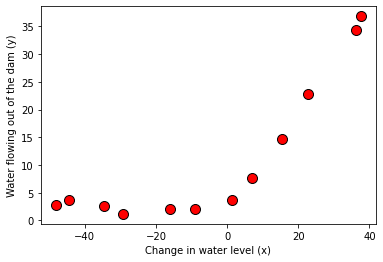

In [4]:
water_prediction.plot_data(X_training,y_training)

Let's perform the training without regularization,

In [5]:
max_iter = 200
lambda_ = 0
theta = water_prediction.scipy_optimize(X_training, y_training, max_iter, lambda_)

Let's plot the hypothesis,

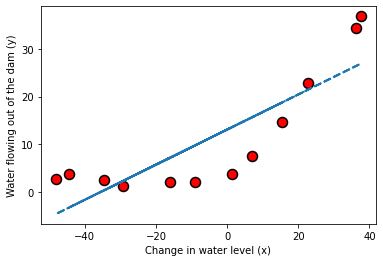

In [6]:
water_prediction.plot_fit(X_training, y_training, theta)

The best fit line shows that the model is not a good fit to the data because the data has a non-linear pattern. While visualizing the best fit as shown is one possible way to debug the learning algorithm, it is not always easy to visualize the data and model. Let's plot the learning curves which can help to debug the learning algorithm even if it is not easy to visualize the data.

In [7]:
error_training, error_validation = water_prediction.learning_curve(X_training, y_training, 
                                                                   X_val, y_val, 
                                                                   max_iter, lambda_)

Let's print the training and cross-validation error,

In [8]:
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m_training):
    print('  \t%d\t\t%f\t%f' % (i+1, error_training[i], error_validation[i]))

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	205.121096
  	2		0.000000	110.302641
  	3		3.286595	45.010231
  	4		2.842678	48.368910
  	5		13.154049	35.865165
  	6		19.443963	33.829962
  	7		20.098522	31.970986
  	8		18.172859	30.862446
  	9		22.609405	31.135998
  	10		23.261462	28.936207
  	11		24.317250	29.551432
  	12		22.373906	29.433818


which is illustrated below,

Text(0, 0.5, 'Error')

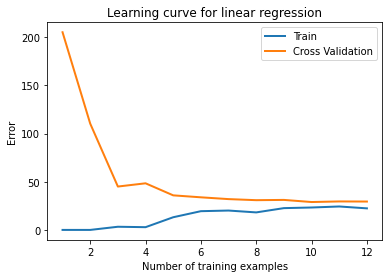

In [9]:
plt.plot(np.arange(1, m_training + 1), error_training, np.arange(1, m_training + 1), error_validation, lw=2)
plt.title('Learning curve for linear regression')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')

In the figure above, both the train error and cross validation error are high when the number of training examples `m` is increased. This reflects a high bias problem in the model. The linear regression model is too simple and is unable to fit the dataset well. In the next section, we will implement polynomial regression to fit a better model for the dataset.

<a id="section3"></a>
## 3:  Water Flow Prediction # PART 2

In section 3, we will predict the water flowing out of the dam using the **Polynomial Regression**.

The existing features will be mapped into higher polynomial order. The project uses `polynomials_order = 8`. Then the features will be normalized.

In [10]:
polynomials_order = 8

In [11]:
X_poly_training = water_prediction.features_mapping(X_training, polynomials_order)
X_poly_training_norm, mean, sigma = water_prediction.features_normalization(X_poly_training)

In [12]:
X_poly_val = water_prediction.features_mapping(X_val, polynomials_order)
X_poly_val_norm = (X_poly_val - mean) / sigma

In [13]:
X_poly_test = water_prediction.features_mapping(X_test, polynomials_order)
X_poly_test_norm = (X_poly_test - mean) / sigma

After features are mapped and normalized, the training could begin. Moreover, the `lambda_` value is randomly chosen.

In [14]:
max_iter = 200
lambda_ = 0
poly_theta = water_prediction.scipy_optimize(X_poly_training_norm, y_training, max_iter, lambda_)

Let's plot the hypothesis,

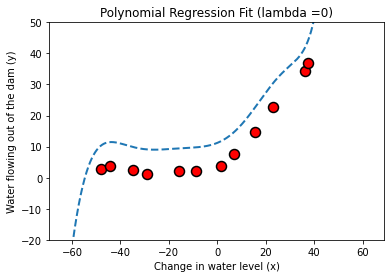

<Figure size 432x288 with 0 Axes>

In [15]:
water_prediction.plot_poly(X_training, y_training,
                           np.min(X_training), np.max(X_training), 
                           mean, sigma, 
                           poly_theta, 
                           polynomials_order)

Let's obtain the `error_train` and `error_val`,

In [16]:
error_train, error_val = water_prediction.learning_curve(X_poly_training_norm, y_training, 
                                                         X_poly_val_norm, y_val, 
                                                         max_iter, lambda_)

Then plot the learning curve,

Text(0, 0.5, 'Error')

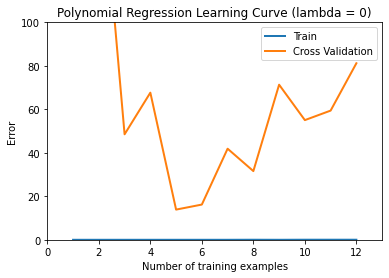

In [17]:
plt.plot(np.arange(1, m_training + 1), error_train, np.arange(1, m_training + 1), error_val, lw=2)
plt.title('Polynomial Regression Learning Curve (lambda = ' + str(lambda_) + ')')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.axis([0, 13, 0, 100])
plt.ylabel('Error')

From the Polynomial Regression fit and the Learning Curve figures, we could see that the `error_train` are close to zero while the `error_val` are high. There is a clear significant gap between `error_train` and `error_val` which indicates a variance problem. The variance problem occurs when the model overfits the training set.

There are some ways to overcome variance problem. One of them is using the regularization. On the next section, we will use regularization and tune the hyperparameter `lambda`.

<a id="section4"></a>
## 4:  Water Flow Prediction # PART 3

In section 4, we will tune the hyperparameter `lambda` to minimize the cost.

After iterations, it is found out the lowest cost is for `lambda` around 1.

In [18]:
max_iter = 200
lambda_ = 1
poly_theta = water_prediction.scipy_optimize(X_poly_training_norm, y_training, max_iter, lambda_)

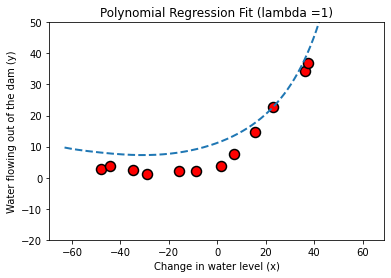

<Figure size 432x288 with 0 Axes>

In [19]:
water_prediction.plot_poly(X_training, y_training,
                           np.min(X_training), np.max(X_training), 
                           mean, sigma, 
                           poly_theta, 
                           polynomials_order)

Text(0, 0.5, 'Error')

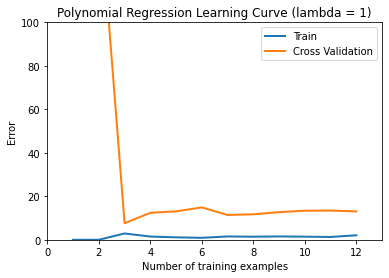

In [20]:
error_train, error_val = water_prediction.learning_curve(X_poly_training_norm, y_training, 
                                                         X_poly_val_norm, y_val, 
                                                         max_iter, lambda_)

plt.plot(np.arange(1, m_training + 1), error_train, np.arange(1, m_training + 1), error_val, lw=2)
plt.title('Polynomial Regression Learning Curve (lambda = ' + str(lambda_) + ')')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.axis([0, 13, 0, 100])
plt.ylabel('Error')

The model seems to fit the training set and cross-validation set pretty well with `lambda = 1`.

Let's see how the model generalize to the test set,

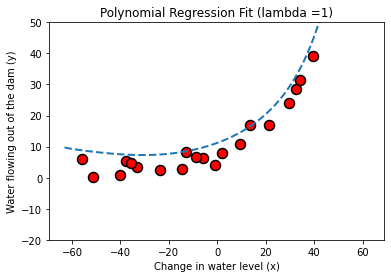

<Figure size 432x288 with 0 Axes>

In [21]:
water_prediction.plot_poly(X_test, y_test,
                           np.min(X_training), np.max(X_training), 
                           mean, sigma, 
                           poly_theta, 
                           polynomials_order)

From the figure above, it seems that the `lambda = 1` able to generalize well to new data (test set). This section suggests that regularization could be used to overcome variance problem.

<a id="section5"></a>
## 5: Conclusion

In this project, we have successfully developed a Machine Learning algorithm using both Linear Regression and Polynomial Regression.

When working on a Machine Learning project, there might be challenges to identify whether the model suffers a bias problem (underfitting) or a variance problem (overfitting). In such a case, the user should consider plotting the learning curve. THe learning curve makes it easier for the user to identify whether a model suffer a bias problem or a variance problem.